In [13]:
# Install necessary packages if they are not already installed
if (!require(caret)) install.packages("caret")
if (!require(rpart)) install.packages("rpart")
if (!require(pROC)) install.packages("pROC")
if (!require(ggplot2)) install.packages("ggplot2")

# Load the libraries
library(caret)
library(rpart)
library(pROC)
library(ggplot2)


Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ipred’, ‘recipes’


Loading required package: rpart

Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice



## Load Data

In [15]:
library(readr)
# Load the dataset
data <- read_csv("/content/car_data.csv")

# View the first few rows of the dataset
head(data)


Rows: 1000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Gender
dbl (4): User ID, Age, AnnualSalary, Purchased

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


User ID,Gender,Age,AnnualSalary,Purchased
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
385,Male,35,20000,0
681,Male,40,43500,0
353,Male,49,74000,0
895,Male,40,107500,1
661,Male,25,79000,0
846,Female,47,33500,1


## Perform Logistic Regression

In [16]:
model_logistic <- glm(Purchased ~ Gender + Age + AnnualSalary, data = data, family = binomial())

# Summary of the model
summary(model_logistic)




Call:
glm(formula = Purchased ~ Gender + Age + AnnualSalary, family = binomial(), 
    data = data)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.218e+01  8.049e-01 -15.131   <2e-16 ***
GenderMale    3.184e-01  1.855e-01   1.716   0.0861 .  
Age           2.195e-01  1.517e-02  14.471   <2e-16 ***
AnnualSalary  3.370e-05  3.232e-06  10.426   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1347.63  on 999  degrees of freedom
Residual deviance:  742.96  on 996  degrees of freedom
AIC: 750.96

Number of Fisher Scoring iterations: 6


##Check for Assumptions

Check for linearity between the logit of the outcome and numeric predictors using basic plots

These plots will show the relationship between each predictor and the log odds of purchasing, with a logistic regression line fitted to the data. The geom_smooth function with method = "glm" and family = "binomial" is used to fit and plot a logistic regression model, showing how the probability of the outcome changes with the predictor.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


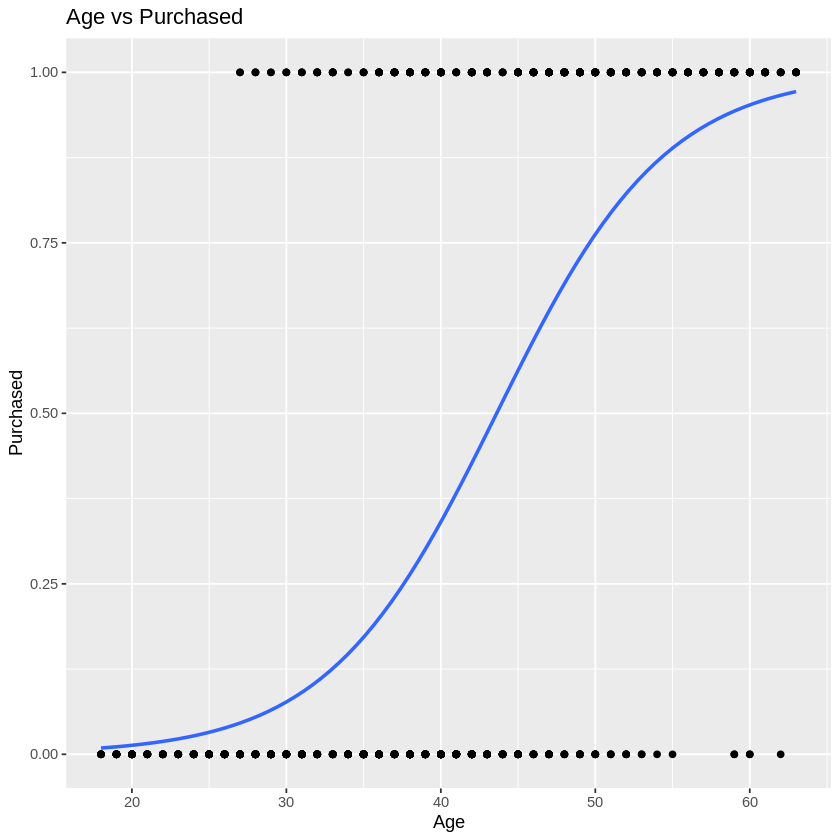

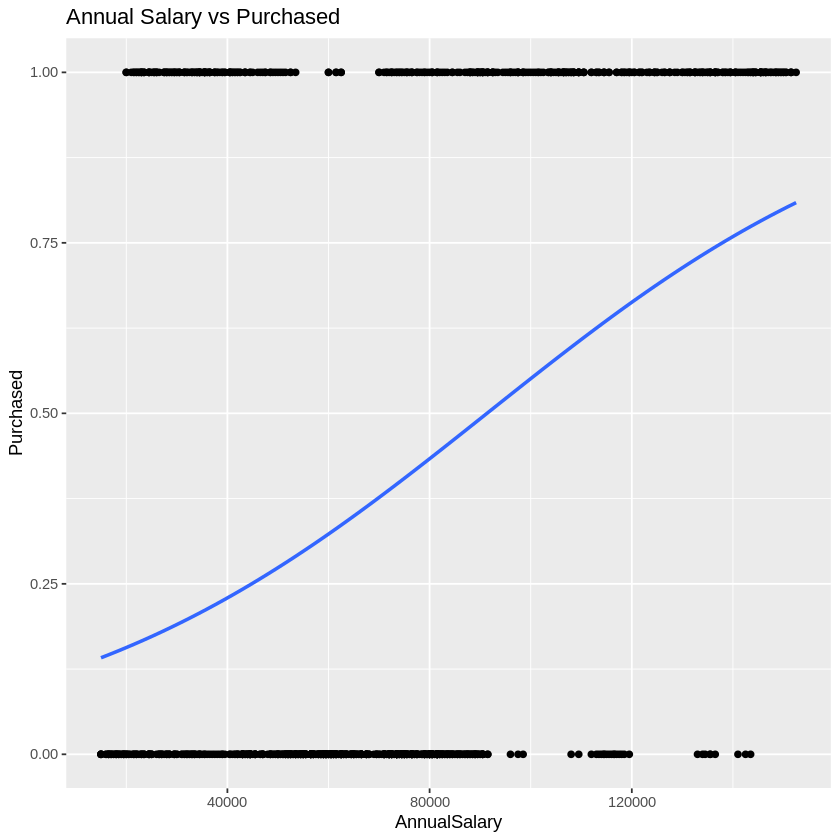

In [17]:
if (!require(ggplot2)) install.packages("ggplot2")
library(ggplot2)

# Age vs Purchased
ggplot(data, aes(x = Age, y = Purchased)) +
  geom_point() +
  geom_smooth(method = "glm", method.args = list(family = "binomial"), se = FALSE) +
  ggtitle("Age vs Purchased")

# AnnualSalary vs Purchased
ggplot(data, aes(x = AnnualSalary, y = Purchased)) +
  geom_point() +
  geom_smooth(method = "glm", method.args = list(family = "binomial"), se = FALSE) +
  ggtitle("Annual Salary vs Purchased")



The Box-Tidwell test outputs p-values for each predictor. If the p-value for a predictor is significant (usually p < 0.05), this suggests that the relationship between the predictor and the logit of the dependent variable is non-linear, and you might need to consider transforming this predictor or using non-linear terms in your model.

In [ ]:
if (!require(car)) install.packages("car")
library(car)

# Prepare data: add a small constant if zeros might be an issue
data$AnnualSalaryAdjusted <- log(data$AnnualSalary + 1)
data$AgeAdjusted <- log(data$Age)

# Perform the Box-Tidwell test
# Note: Include interaction terms with log-transformed predictors
box_tidwell_results <- boxTidwell(Purchased ~ AgeAdjusted + AnnualSalaryAdjusted + Gender,
                                  data = data,
                                  global = TRUE)  # 'global=TRUE' provides an overall test statistic

# Print the results
print(box_tidwell_results)



Loading required package: car

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘car’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘pbkrtest’, ‘lme4’




## Confusion Matrix & ROC curve

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 539 105
         1  59 297
                                          
               Accuracy : 0.836           
                 95% CI : (0.8116, 0.8584)
    No Information Rate : 0.598           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6524          
                                          
 Mcnemar's Test P-Value : 0.0004416       
                                          
            Sensitivity : 0.9013          
            Specificity : 0.7388          
         Pos Pred Value : 0.8370          
         Neg Pred Value : 0.8343          
             Prevalence : 0.5980          
         Detection Rate : 0.5390          
   Detection Prevalence : 0.6440          
      Balanced Accuracy : 0.8201          
                                          
       'Positive' Class : 0               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9156

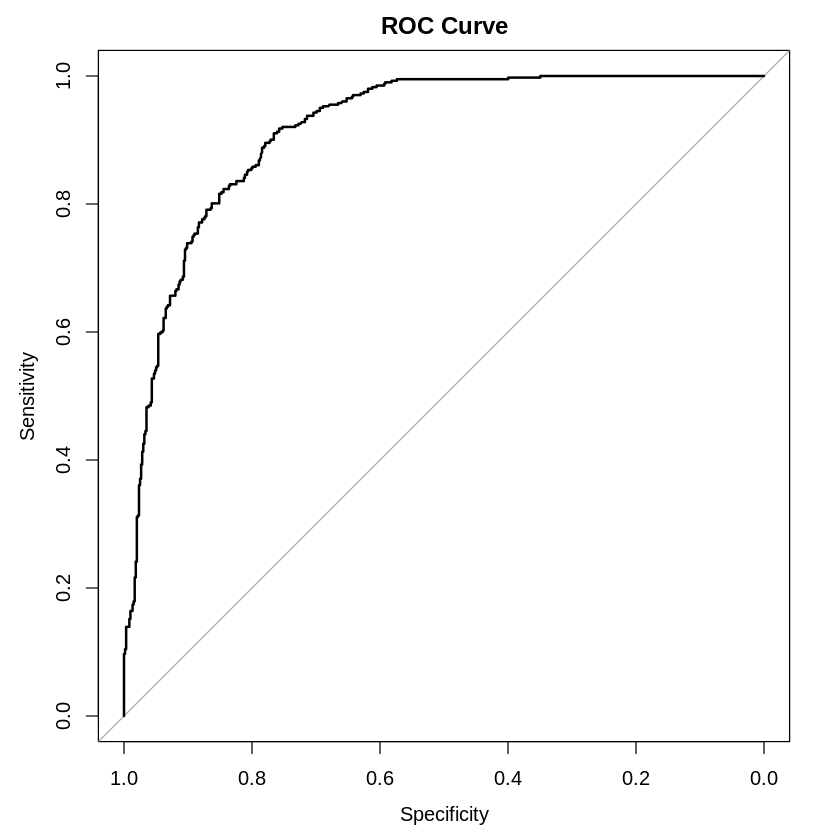

In [18]:

# Predict probabilities
probabilities <- predict(model_logistic, newdata = data, type = "response")
# Convert probabilities to binary outcome
predicted_classes <- ifelse(probabilities > 0.5, 1, 0)
# Actual outcomes
actual_classes <- data$Purchased
# Confusion matrix
conf_matrix <- confusionMatrix(factor(predicted_classes), factor(actual_classes))
print(conf_matrix)

# ROC curve
library(pROC)
roc_curve <- roc(actual_classes, probabilities)
plot(roc_curve, main="ROC Curve")
auc(roc_curve)


## Decision Tree

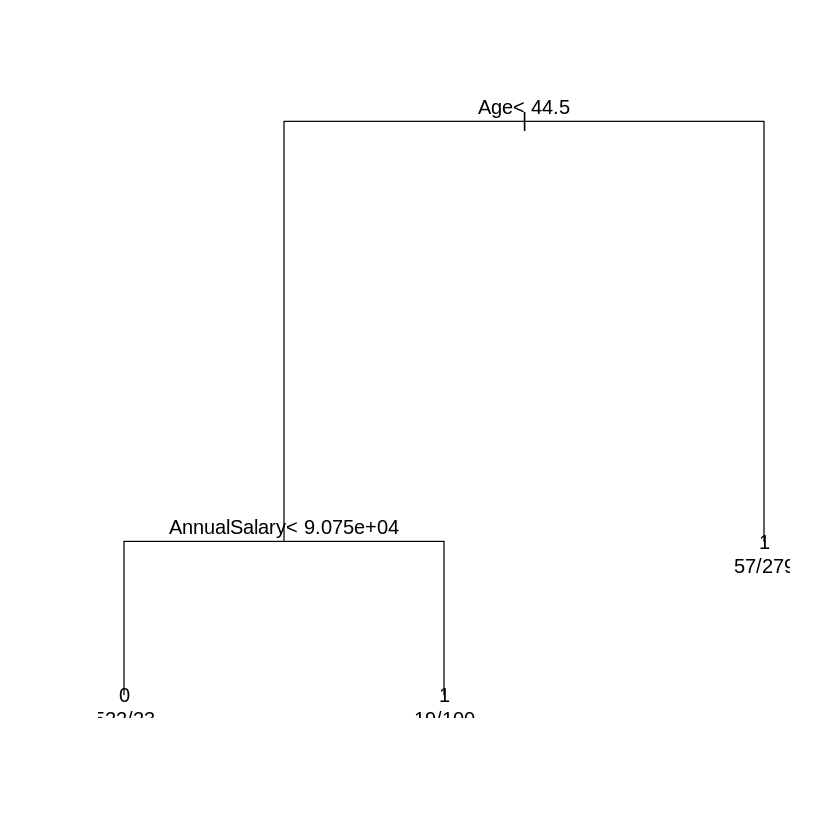

In [19]:
library(rpart)
# Fitting a decision tree
model_tree <- rpart(Purchased ~ Gender + Age + AnnualSalary, data = data, method="class")

# Plotting the tree
plot(model_tree)
text(model_tree, use.n=TRUE)


In [20]:
# Print model metrics for comparison
print(paste("AUC for Logistic Regression:", auc(roc_curve)))
# Accuracy for decision tree can be calculated similarly if needed


[1] "AUC for Logistic Regression: 0.915620476214246"


# Metrics Comparison and critical analysis

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



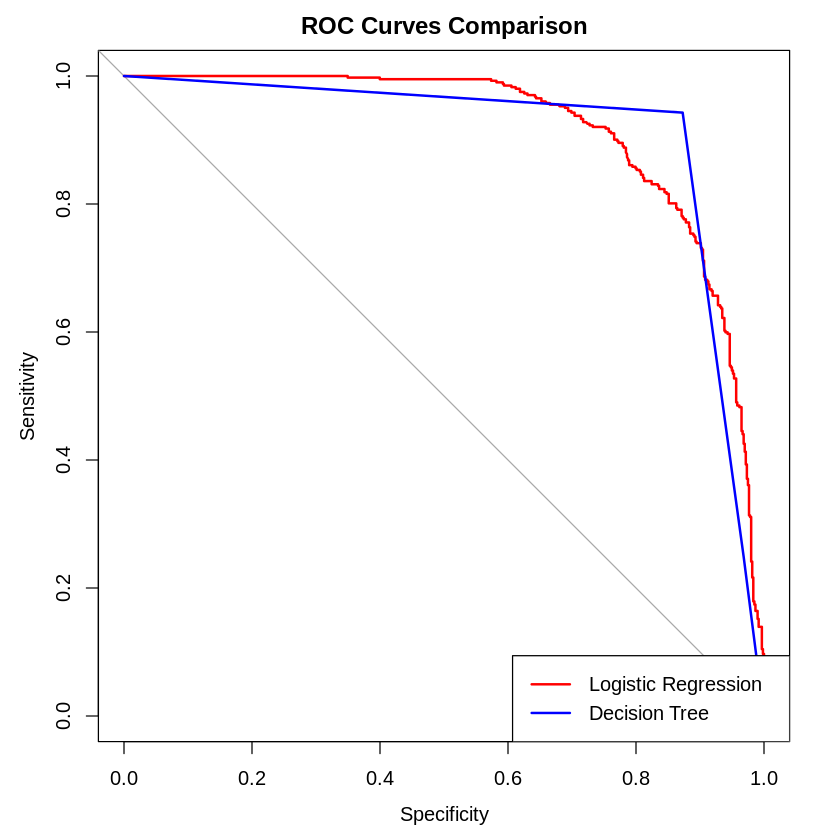

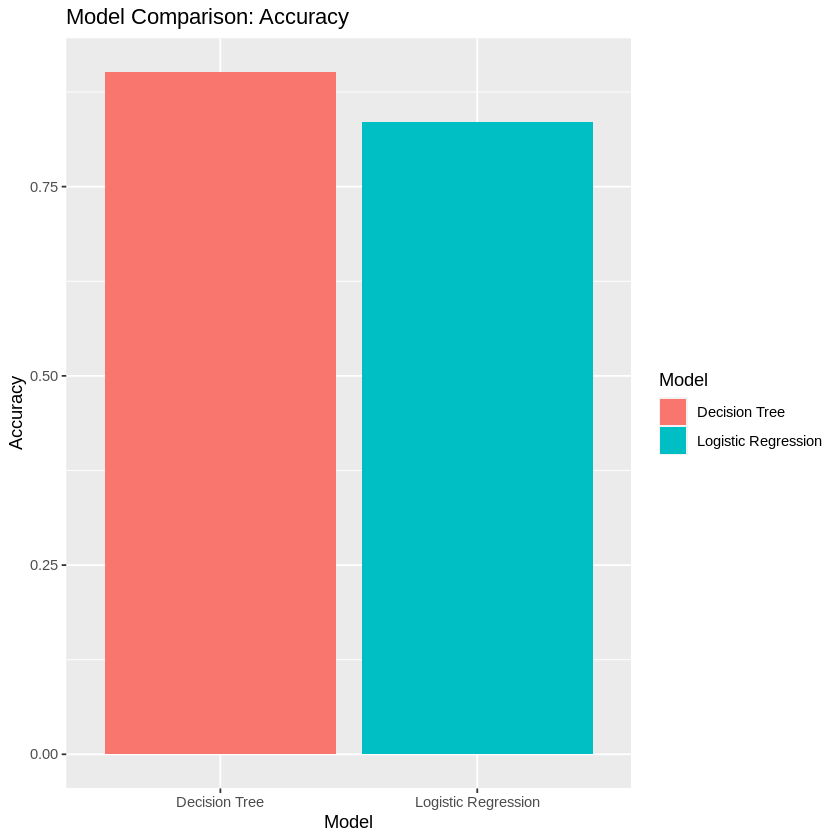

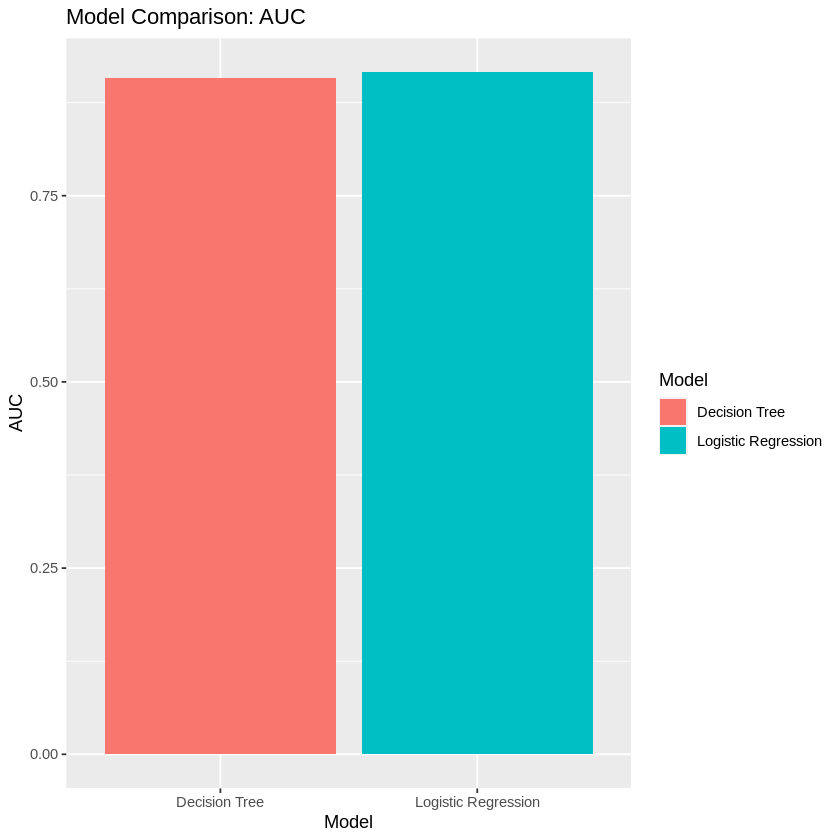

In [21]:
# Fit Logistic Regression Model
model_logistic <- glm(Purchased ~ Gender + Age + AnnualSalary, data = data, family = binomial())

# Fit Decision Tree Model
model_tree <- rpart(Purchased ~ Gender + Age + AnnualSalary, data = data, method = "class")

# Logistic Regression Predictions
probabilities_logistic <- predict(model_logistic, newdata = data, type = "response")
predicted_classes_logistic <- ifelse(probabilities_logistic > 0.5, 1, 0)

# Decision Tree Predictions
probabilities_tree <- predict(model_tree, newdata = data, type = "prob")[,2]
predicted_classes_tree <- ifelse(probabilities_tree > 0.5, 1, 0)

# Calculate ROC and AUC
roc_logistic <- roc(data$Purchased, probabilities_logistic)
roc_tree <- roc(data$Purchased, probabilities_tree)
auc_logistic <- auc(roc_logistic)
auc_tree <- auc(roc_tree)

# Plot ROC Curves
plot(roc_logistic, col = "red", main = "ROC Curves Comparison", xlim = c(0, 1), ylim = c(0, 1))
lines(roc_tree, col = "blue", add = TRUE)
legend("bottomright", legend = c("Logistic Regression", "Decision Tree"),
       col = c("red", "blue"), lwd = 2)

# Calculate accuracy
accuracy_logistic <- sum(predicted_classes_logistic == data$Purchased) / length(data$Purchased)
accuracy_tree <- sum(predicted_classes_tree == data$Purchased) / length(data$Purchased)

# Create a data frame for plotting
comparison_data <- data.frame(
  Model = c("Logistic Regression", "Decision Tree"),
  Accuracy = c(accuracy_logistic, accuracy_tree),
  AUC = c(auc_logistic, auc_tree)
)

# Plot Accuracy Comparison
ggplot(comparison_data, aes(x = Model, y = Accuracy, fill = Model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  ggtitle("Model Comparison: Accuracy")

# Plot AUC Comparison
ggplot(comparison_data, aes(x = Model, y = AUC, fill = Model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  ggtitle("Model Comparison: AUC")
